In [1]:
from scipy.io import loadmat
import numpy as np 
import matplotlib.pyplot as plt
import time
from scipy.io import loadmat
from scipy.sparse.linalg import svds, bicg, inv, LinearOperator
from scipy.sparse import diags
from scipy.linalg import pinv

# 1 X-ray tomography

In [2]:
H = loadmat('data/H.mat')['H']
x = loadmat('data/x.mat')['x']
G = loadmat('data/G.mat')['G']

In [3]:
hx = H@x
y = hx + np.random.normal(size = hx.shape, scale=1)

In [4]:
y_view = y.reshape((90,180), order='F')
x_view = x.reshape((90,90), order='F')

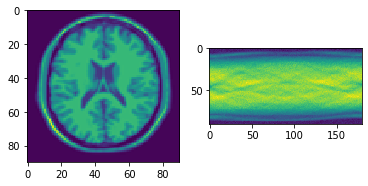

In [5]:
fg , ax = plt.subplots(1,2)
ax[0].imshow(x_view)
ax[1].imshow(y_view)

# 2 Optimization problem

Given that $$\left(\forall x \in \mathbb{R}^{N}\right) \quad f(x)=\frac{1}{2}\|H x-y\|^{2}+\lambda r(x)$$

With, $$\left(\forall x \in \mathbb{R}^{N}\right) \quad r(x)=\sum_{n=1}^{2 N} \psi\left([G x]^{(n)}\right)$$

With, $$\left(\forall u \in \mathbb{R}\right) \quad \psi(u)=\sqrt{1+\frac{u^{2}}{\delta^{2}}}$$

---

One has :$$\left(\forall x \in \mathbb{R}^{N}\right) \quad \nabla f=H^{\top} H x - H^{\top} y + \lambda \nabla r(x)$$
$$\left(\forall x \in \mathbb{R}^{N}\right) \quad \lambda\nabla r = \lambda G^{\top}\psi^{\prime}(G x)$$
with $$\psi^{\prime}(u)=\frac{u}{\delta^{2} \sqrt{1+\frac{u^{2}}{\delta^{2}}}}$$ applied to each component of $G x$.

In [6]:
def f(x, y ,r, lambda_) : 
    return(1/2 * np.linalg.norm(H@x - y, ord=2) + labmda_ * r(x))

In [7]:
lambda_ , delta = 0.13, 0.02

In [8]:
def grad_f(x) : 
    return(H.T @ (H @ x) - H.T @ y + lambda_ * G.T @ grad_psi(G @ x))

def grad_psi(u, delta=delta): 
    return(u / ( delta ** 2 * np.sqrt(1 + u ** 2 / ( delta ** 2 ))))

def h(x): 
    
    return(f(x_n) + np.dot(grad_f(x_n), x - x_n) + 1/2 * np.sqrt(np.dot(x - x_n, A @ (x - x_n))))

Moreover, given that :$$\nabla f=H^{\top} H x-H^{\top} y+\lambda G^{\top} \Psi^{\prime}(G x)$$
One has, 
$$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\| = \left\|H^{\top} H (x_{1}-x_{2}) + \lambda G^{\top} \psi^{\prime}(G x_{1}) - \psi^{\prime}(G x_{2}) \right\|$$
Thus with $\lambda>0$ and using the triangle inequality, 
$$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\|\leq \left\|H^{\top} H (x_{1}-x_{2})\right\| + \lambda \left\|G^{\top}\psi^{\prime}(G x_{1}) - G^{\top}\psi^{\prime}(G x_{2})\right\|$$
$$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\|\leq \left\|H^{\top} H (x_{1}-x_{2})\right\| + \lambda \left\|G\right\| \left\|\psi^{\prime}(G x_{1}) - \psi^{\prime}(G x_{2})\right\|$$
Then by the fact that $$\left(\forall u \in \mathbb{R}\right) \quad \left\|\psi^{\prime}(u)\right\|=\left\|\frac{u}{\delta^{2} \sqrt{1+\frac{u^{2}}{\delta^{2}}}}\right\| \leq \left\|\frac{u}{\delta^{2}}\right\|$$ we know that $\frac{1}{\delta^{2}}$ is a Lipschitz constant of $\psi^{\prime}$.
And thus, $$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\| \leq \left\|H\right\|^{2} \left\|x_{1}-x_{2}\right\| + \lambda \left\|G\right\| \frac{1}{\delta^{2}} \left\|G x_{1} - G x_{2}\right\|$$
And finally : $$\left\|\nabla f(x_{1})-\nabla f(x_{2})\right\| \leq \left(\left\|H\right\|^{2}+ \frac{\lambda}{\delta^{2}} \left\|G\right\|^{2}\right) \left\|x_{1} - x_{2}\right\|$$

Thus, $L=\|H\|^{2}+\left(\lambda / \delta^{2}\right)\|G\|^{2}$ is a Lipschitz constant of $\nabla f$, which for $(\lambda, \delta)=(0.13,0.02)$ gives $L=1.809e+04$.

Detailed computation of L in this case :

In [9]:
def lipschitz_constant(G,H, lambda_=0.13, delta=0.02):
    _, singular_value_G, _ = svds(G)
    _, singular_value_H, _ = svds(H)
    return(max(singular_value_H) ** 2 + (lambda_ / (delta ** 2 )) * (max(singular_value_G)**2))

In [10]:
print("The lipschitz constant of the gradient of f is : {:.3e}".format(lipschitz_constant(G,H)))

The lipschitz constant of the gradient of f is : 1.809e+04


# 3 Optimization algorithms
## 3.1 Gradient Descent Algorithm 

In [11]:
M, N = 90 * 180, 90 * 90 
x_0 = np.zeros((N,1))

44.94714266020643
0.43239348307781306
0.2040399159291014
0.12661282635285384
0.08484528504786013
0.05996878714268457
0.04421828716298335
0.0338002353940583
0.02666619316655741
0.02162845466750604
0.017965852851810148
0.015224621575730967
0.013115546100573158
0.011455195229364772
0.010122448291302284
0.009032997737078337
0.008127050547452684
0.007361214247275425
0.006703333044160296
0.006130195240184809
0.005625296493635162
0.005176397851232827
0.004774187554024843
0.004411696915740488
0.00408358736716176
0.0037854810592961525
0.003513677762904034
0.003265143245176634
0.003037494080819826
0.0028288577668108363
0.0026376663404475884
0.002462486282070407
0.0023019327672178327
0.002154658223445928
0.0020193810205383035
0.0018949211067751496
0.0017802217991312226
0.0016743513302271377
0.0015764885501040745
0.0014859021454832594
0.0014019320038015466
0.00132397711085668
0.0012514898644841968
0.0011839741802183602
0.0011209845416114753
0.0010621241934506125
0.0010070418897685644
0.00095542742

Text(0.5, 1.0, 'Reconstruction result, Gradient Descent algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, normalized_error=9.8435e-05')

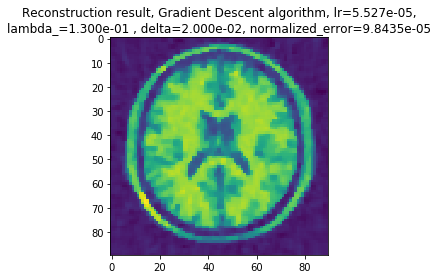

In [12]:
learning_rate = 1/lipschitz_constant(G,H)
def grad_desc(lambda_=lambda_, delta=delta, learning_rate=1e-4, eps=1e-6, max_iter=1000):
    history = []
    x_n = x_0.copy()
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        grad = grad_f(x_n)
        x_n1 = x_n - learning_rate * grad
        #new_norm = np.sum(np.abs(x_n1 - x_n))
        new_norm = np.linalg.norm(x_n1 - x_n, ord='fro')
        history.append(new_norm)
        if new_norm < 1e-6 * np.linalg.norm(x_n, ord='fro'):#np.sum(np.abs(x_n)) : 
            converged = True
        if itr % 10 == 0: 
            print(new_norm)
        x_n = x_n1.copy()
        itr+=1

    end = time.time()
    print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))
    
    return x_n, new_norm, history
    
x_rec_GD, norm_GD, history_GD = grad_desc()
x_rec_GD_view = x_rec_GD.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_GD_view)
ax.set_title('Reconstruction result, Gradient Descent algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, normalized_error={2:.4e}'.format(lambda_, delta, norm_GD))

## 3.2 MM quadratic algorithm

For every $y \in \mathbb{R}^{N}$ we will look for a self-adjoint operator A such that :$$(\forall x \in \mathbb{R}^{N}) \quad h(x, y)=f(y)+\langle\nabla f(y) | x-y\rangle+\frac{1}{2}\|x-y\|_{A(y)}^{2}$$ is a majorant function of f at y.

We will construct $\Delta$ such that :$$(\forall x \in \mathbb{R}^{N}) \quad \Delta=\operatorname{diag}\left\{\frac{\psi^{\prime}(x_{i})}{x_{i}}\right\}_{i \in \{1, \ldots, N\}}$$ because $\psi(\sqrt{.})$ is concave, $\psi$ is positive and $\lim_{u \to 0^{+}} \frac{\psi(u)}{u}$ is finite.

And then we choose A as : $$(\forall x \in \mathbb{R}^{N}) \quad A(x)=H^{\top}H + \lambda G^{\top} \Delta(G x) G$$

In [13]:
# from scipy.io import loadmat
# from scipy.sparse.linalg import svds, bicg, inv, LinearOperator
# from scipy.sparse import diags
# from scipy.linalg import pinv

In [14]:
diags((grad_psi(x)/x).flatten()).tocsc()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


<8100x8100 sparse matrix of type '<class 'numpy.float64'>'
	with 8100 stored elements in Compressed Sparse Column format>

In [15]:
def big_delta(x, delta, eps = 1e-10):
    return diags((grad_psi(x, delta)/(x+eps)).flatten()).tocsc()

36.53689829859253
0.05110846965169992
0.008344136526722688
0.0020323098481069683
0.0005811988462602665
0.0001828645569693
6.170688896324311e-05
It took 67 iterations and 40.94 seconds to converge.


Text(0.5, 1.0, 'Reconstruction result, Gradient Descent algorithm, lr=5.527e-05,\nlambda_=1.300e-01 , delta=2.000e-02, normalized_error=3.3119e-05')

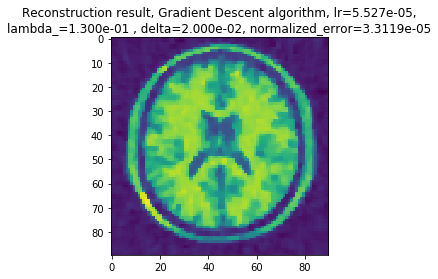

In [16]:
def MM_quad(lambda_=lambda_, delta=delta, eps=1e-6, max_iter=1000):
    history = []
    x_n = x_0.copy()
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        grad = grad_f(x_n)
        A_x = lambda x : (H.T.dot(H.dot(x)) + lambda_ * G.T.dot(big_delta(G.dot(x_n), delta).dot(G.dot(x))))
        A = LinearOperator((N,N),matvec = A_x, rmatvec = A_x)
        x_n1 = x_n - bicg(A, grad, tol=1e-3)[0].reshape(-1, 1)
        new_norm = np.linalg.norm(x_n1 - x_n, ord='fro')
        history.append(new_norm)
        if new_norm < eps * np.linalg.norm(x_n, ord='fro'): 
            converged = True
        if itr % 10 == 0: 
            print(new_norm)
        x_n = x_n1.copy()
        itr+=1
        
    end = time.time()
    print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))

    return x_n, new_norm, history
    
x_rec_MM, rec_error_MM, history_MM = MM_quad()
x_rec_MM_view = x_rec_MM.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_MM_view)
ax.set_title('Reconstruction result, Gradient Descent algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, normalized_error={2:.4e}'.format(lambda_, delta, rec_error_MM))

## 3.3 3MG algorithm

We will minimize the quadratic majorant function using the subspace spanned by :$$(\forall k \in \mathbb{N}) \quad D_{k}=\left[-\nabla f\left(x_{k}\right) \quad | \quad x_{k}-x_{k-1}\right]$$
Thus, at iterate k, one has : $$(\forall k \in \mathbb{N}) \quad x_{k+1}=x_{k}+D_{k} u_{k}$$
with $$(\forall k \in \mathbb{N}) \quad u_{k}=-\left(D_{k}^{\top} A\left(x_{k}\right) D_{k}\right)^{\dagger}\left(D_{k}^{\top} \nabla f\left(x_{k}\right)\right)$$
with $M^{\dagger}$ the pseudo inverse of M (obtained using np.linalg.pinv($\Delta$).
Which can be rewritten : $$(\forall k \in \mathbb{N}) \quad u_{k}=-\left((H D_{k})^{\top} (H D_{k}) + \lambda (G D_{k})^{\top} \Delta\left(G x_{k}\right) (G D_{k}) \right)^{\dagger}\left(D_{k}^{\top} \nabla f\left(x_{k}\right)\right)$$

In [ ]:
def MMMG(lambda_=lambda_, delta=delta, eps=1e-6, max_iter=1000):
    history = []
    x_n = x_0.copy()
    converged = False
    itr = 0
    begin = time.time()
    while itr < max_iter and not converged : 
        grad = grad_f(x_n)
        if itr==0:
            D_n = -grad
        else:
            D_n = np.concatenate((-grad, x_n - x_old), axis=1)
        D_n = D_n.reshape(N,-1)
        matrix_shape = D_n.shape[1]
        sub_A_x = lambda x : ((H@D_n).T.dot((H@D_n)) + lambda_ * (G@D_n).T.dot(big_delta(G.dot(x_n),
                                                                                    delta).dot((G@D_n)))).dot(x)
        A = LinearOperator((matrix_shape,matrix_shape),matvec = sub_A_x, rmatvec = sub_A_x)
        b = D_n.T@grad
        x_n1 = x_n - D_n@bicg(A, b, tol=1e-3)[0].reshape(-1, 1)
        #new_norm = np.sum(np.abs(x_n1 - x_n))
        new_norm = np.linalg.norm(x_n1 - x_n, ord='fro')
        history.append(new_norm)
        if new_norm < eps * np.linalg.norm(x_n, ord='fro'):#np.sum(np.abs(x_n)) : 
            converged = True
        if itr % 10 == 0: 
            print(new_norm)
        x_old = x_n.copy()
        x_n = x_n1.copy()
        itr+=1
        
    end = time.time()
    print('It took {0} iterations and {1:.2f} seconds to converge.'.format(itr,end-begin))

    return x_n, new_norm, history
    
x_rec_MMMG, rec_error_MMMG, history_MMMG = MMMG()
x_rec_MMMG_view = x_rec_MMMG.reshape((90,90), order='F')
fg, ax = plt.subplots(1,1)
ax.imshow(x_rec_MMMG_view)
ax.set_title('Reconstruction result, Gradient Descent algorithm, lr={0:.3e},'.format(learning_rate)
             +'\nlambda_={0:.3e} , delta={1:.3e}, normalized_error={2:.4e}'.format(lambda_, delta, 
                                                                                   rec_error_MMMG))

29.27079766170973
0.4877735344568115
0.24608725735374778
0.1450342249692157
0.09356004478535926
0.06463019769993972
0.047261813036796246
0.0362647802678164
0.02894745545204536
0.0238314470239002
0.02009418699842485
0.01726654029327502
0.015058757503509568
0.013284633285358132
0.011819608625873322
0.010581491718013297
0.009517146115239229
0.008590071546195623
0.0077749966706479445
0.0070539205406209655
0.006412633326255741
0.005839797615260817
0.005326941461691627
0.004867713447941121
0.00445673962907058
0.004088907235358935
0.003759244785324236
0.0034631146625329163
0.0031964109095365236
0.002955614699686448
0.00273771815903258
0.0025401033434500446
0.0023604512699771088
0.0021967026120377226
0.002047041752828926
0.0019098986596800486
0.00178392579813565
0.00166797283977304
0.0015610547462681524
0.0014623205001688747
0.0013710260556652777
0.0012865128949477124
0.00120819204973965
0.001135532660860829
0.0010680538996322914
0.001005319168979242
0.0009469317338038505
0.0008925311763338288

#### HMM PROBLEME ICI, NORMALEMENT CA DEVRAIT ACCELERER LA CONVERGENCE...